## Working with point data on the sphere

In this notebook we read in the global heat flow data available through XXXX and explore a number of different stragegies for
building useful triangulations to help process this data.

The heat flow measurements in this database are globally sparse but contain regional surveys where the density of points is very much higher than average. In some of the regional surveys, data have been obtained along transects or have been processed into evenly spaced grid points. 
We will build the following different triangulations

  - A naive triangulation of the given points 
  - A triangulation constructed by subdivision so that no point has more than a certain number of 'nearby' points from the dataset
  - A triangulation constructed by subdivision so that no triangle contains more than a certain number of data points
  - A triangulation in which points are removed if they are not the nearest point to any data point (a post-processing of the above hierarchical triangulations)
  


In [1]:
import gdal

import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
gtiff = gdal.Open("/Users/lmoresi/+Codes/Python/quagmire/Notebooks/data/ETOPO1_Ice_c_geotiff.tif")

width = gtiff.RasterXSize
height = gtiff.RasterYSize
gt = gtiff.GetGeoTransform()
img = gtiff.GetRasterBand(1).ReadAsArray().T

img = np.fliplr(img)

imgLR = img[::10,::10]

In [3]:
grid0 = stripy.icosahedral_mesh(include_face_points=False, refinement_levels=0)
grid3 = stripy.icosahedral_mesh(include_face_points=False, refinement_levels=3)
gridR = stripy.icosahedral_mesh(include_face_points=False, refinement_levels=8)

print grid0.npoints, grid3.npoints, gridR.npoints

12 642 655362


In [4]:
dlons = np.mod(np.degrees(gridR.lons)+180.0, 360.0)
dlats = np.mod(np.degrees(gridR.lats)+90, 180.0)

ilons = img.shape[0] * dlons / 360.0
ilats = img.shape[1] * dlats / 180.0

icoords = np.stack((ilons, ilats))

from scipy import ndimage

meshheights = ndimage.map_coordinates(img, icoords , order=3, mode='nearest').astype(np.float)

In [5]:
# datafile = "/Users/lmoresi/Dropbox/+Research/Publications/MyPapers/CooperMiller-ContinentalStructure/Data/te_dat.xyte.txt"

datafile = "HeatFlowGlobal2010.csv"
hf_data = np.genfromtxt(datafile, delimiter=",", comments=None, skip_header=1, missing_values=0.0, filling_values=0.0, invalid_raise=False)


In [6]:
la = hf_data[:,0]
lo = hf_data[:,1]
dT = hf_data[:,6] 

valid = np.logical_and(dT > 0.0, dT < 100.0)

lats = la[valid]
lons = lo[valid]
data = dT[valid]

lons = lons+np.random.random(lons.shape)*.00001
lats = lats+np.random.random(lons.shape)*.00001

data_xyz = np.array( stripy.spherical.lonlat2xyz(np.radians(lons), np.radians(lats))).T

print "Valid data points:", data.shape[0]

Valid data points: 27730


In [7]:
## Naive meshing of the data points

datagrid = stripy.sTriangulation(np.radians(lons), np.radians(lats))


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


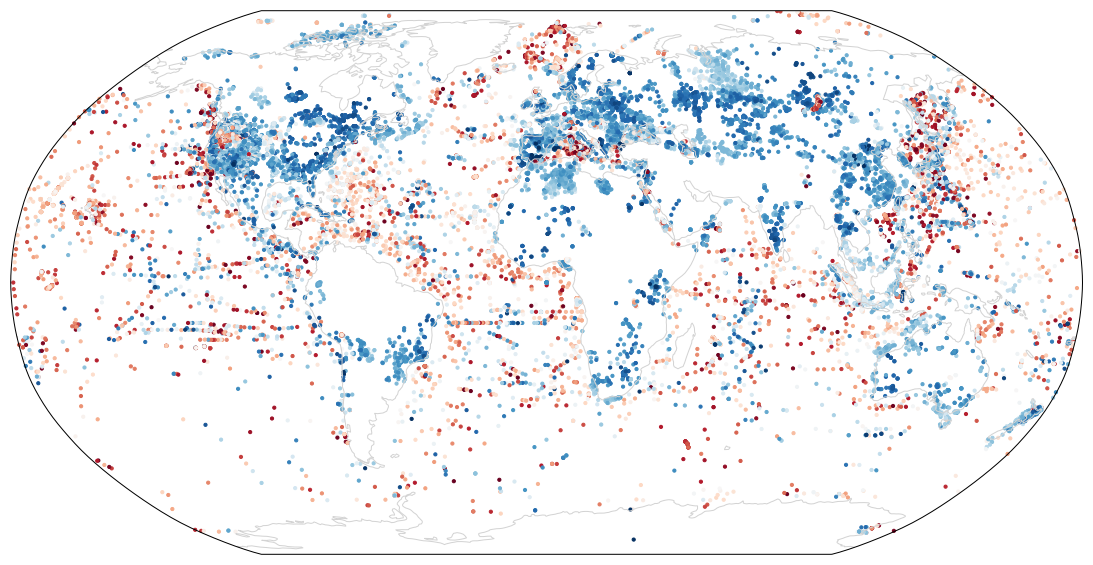

In [8]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Robinson(central_longitude=0.0, globe=None))
ax.coastlines(color="lightgrey")
ax.set_global()

ax.scatter(lons, lats, c=data, cmap=plt.cm.RdBu_r,
            marker="o", s=10.0, transform=ccrs.Geodetic())

fig.show()

In [10]:
import lavavu

striangulationR = gridR
striangulation0 = grid3

wireframeI = striangulationR
trianglesI = striangulationR



lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[2000,1000], near=-10.0)

# Core 

tris = lv.triangles("LAB",  wireframe=False, colour="#999999", opacity=1.0)
tris.vertices(striangulation0.points * 0.95 )
tris.indices(striangulation0.simplices)

tris3 = lv.triangles("datagrid",  wireframe=False, colour="#77ff88", opacity=1.0)
tris3.vertices(datagrid.points)
tris3.indices(datagrid.simplices)
tris3.values(data)
tris3.colourmap(["#555599","#995555"])
                
tris2 = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=0.5)
tris2.vertices(trianglesI.points * (1.0+0.000003*meshheights.reshape(-1,1)))
tris2.indices(trianglesI.simplices)
tris2.values(meshheights*0.001)
tris2.colourmap(["(-5.0)#555555", "(-0.001)#FFFFFF", "(0.0)#779977", "(0.1)#99AA99", "(1.0)#BBDDBB", "(5.0)#EEFFEE"] , logscale=False, range=[-7.0,5.0])   # Apply a built in colourmap

nodes = lv.points("DataPoints", pointsize=5.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(data_xyz*1.01)
nodes.values(data)
nodes.colourmap(["Blue","Red"])

lv.window()

tris.control.Checkbox(property='wireframe', label="Core - wireframe")
tris2.control.Checkbox(property='wireframe', label="Surface - wireframe")
tris3.control.Checkbox(property='wireframe', label="Data - wireframe")


# tris2.control.show()

lv.control.Range('specular', range=(0,1), step=0.1, value=0)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
def weighted_average_to_nodes(lons, lats, data, interpolator ):

    grid   = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!

    for i in range(0, len(data)):

        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        

    grid[np.where(norm > 0.0)] /= norm[np.where(norm > 0.0)]
    
    return grid, norm, count



In [13]:
grids = [grid0]

for i in range(0, 20):

    ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), data, grids[-1])
    
    node_area = np.zeros(grids[-1].npoints)
    t_areas = grids[-1].areas()

    for t,simplex in enumerate(grids[-1].simplices):
        node_area[simplex] += t_areas[t] 
  
    node_area /= node_area.max()
    
    vertices = np.where(np.logical_and(norm > 10.0, node_area > 0.001))[0]

    print vertices.shape[0], norm.min(), norm.max(), count.min(), count.max(), node_area.min()
    
    if vertices.shape[0] == 0:
        break

    newlons, newlats = grids[-1].edge_refine_triangulation_by_vertices(vertices=vertices)
    rgrid = stripy.sTriangulation(newlons, newlats)
    print newlons.shape[0], rgrid.npoints
    grids.append(rgrid)


ave_data, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), data, grids[-1])

## limit the minimum area


12 224.8999931998393 4549.892703705222 1187 17000 0.9998060906449344
42 42
42 28.781035060018993 3086.605047563304 118 6388 0.7802295176571247
162 162
150 1.6506135348966353 1953.2103159311887 7 4000 0.7383229467045013
636 636
362 0.0 995.1524047829263 0 2970 0.2817997039557577
2146 2146
534 0.0 462.7607924053096 0 1213 0.07035997591469671
5055 5055
616 0.0 464.23449315858596 0 698 0.017587647989348896
9009 9009
547 0.0 251.16597732518375 0 570 0.0043965591582186304
12911 12911
377 0.0 126.63947153451704 0 345 0.0010991177329580072
16011 16011
0 0.0 71.92417138062818 0 131 0.0002748688119163936


In [14]:
# Nodes where norm == 0 need to be interpolated ... 

zero_points = np.where(norm == 0.0)

lons = grids[-1].lons[zero_points]
lats = grids[-1].lats[zero_points]


fixed_points, error_codes = datagrid.interpolate(lons, lats, data,order=1)

ave_data[zero_points] = fixed_points

In [16]:
import lavavu

striangulationR = grids[-1]
striangulation0 = grids[2]

wireframeI = striangulationR
trianglesI = gridR

refined_data = ave_data

opacity = norm / norm.max()

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,1000], near=-10.0)

# Core 

tris = lv.triangles("LAB",  wireframe=False, colour="#999999", opacity=1.0)
tris.vertices(striangulation0.points * 0.95 )
tris.indices(striangulation0.simplices)

tris3 = lv.triangles("datagrid",  wireframe=True, colour="#77ff88", opacity=1.0)
tris3.vertices(striangulationR.points)
tris3.indices(striangulationR.simplices)
tris3.values(ave_data, label="data")
tris3.colourmap(["#555599 #995555"])

tris2 = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=0.5)
tris2.vertices(trianglesI.points * (1.0+0.000003*meshheights.reshape(-1,1)))
tris2.indices(trianglesI.simplices)
tris2.values(meshheights*0.001, label="height")
tris2.colourmap(["(-5.0)rgba(0.5,0.5,0.5,0) (-0.001)#FFFFFF (0.0)#779977 (0.1)#99AA99 (1.0)#BBDDBB (5.0)#EEFFEE"] , logscale=False, range=[-7.0,5.0])   # Apply a built in colourmap

# tris2.colourmap(["Green Blue"] ,  monochrome=False)   # Apply a built in colourmap


nodes = lv.points("DataPoints", pointsize=1.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(data_xyz*1.001)
nodes.values(data)
nodes.colourmap(["#00FF00 #FF0000"])

tris.control.Checkbox(property='wireframe', label="Core - wireframe")
tris2.control.Checkbox(property='wireframe', label="Surface - wireframe")
tris3.control.Checkbox(property='wireframe', label="Data - wireframe")

# tris2.control.show()

lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
lv.control.show()


<IPython.core.display.Javascript object>

In [17]:
striangulationR = grids[-1]
refined_data = ave_data
weights = 0.01 + norm / norm.max()

smooth_d, deriv = striangulationR.smoothing(refined_data, weights, 10.0, 0.5, 0.01)


In [ ]:
norm.shape, grids[-1].npoints

In [ ]:
99=1

In [ ]:
## Define a base mesh that we will refine later

mesh = stripy.icosahedral_mesh(refinement_levels=1, include_face_points=True)

print "Size of mesh - 1 ", mesh.npoints

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.colors as colors

global_extent     = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=30, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()


In [ ]:
# valid_map = np.isnan(te_data)
# valid_point = np.empty(te_data.shape[0])

# for i in range(0,len(valid_point)):
#     valid_point[i] = np.logical_not(np.any( valid_map[i,:] ))
     
# print np.count_nonzero(valid_point), " points are valid"

# lons = te_data[np.where(valid_point),0].reshape(-1)
# lats = te_data[np.where(valid_point),1].reshape(-1)
# te   = te_data[np.where(valid_point),2].reshape(-1)


In [ ]:
## Background image

globaletopo = gdal.Open("/Users/lmoresi/+Codes/Python/quagmire/Notebooks/data/ETOPO1_Ice_c_geotiff.tif")


# globaletopo_img   = globaletopo.ReadAsArray()[::30,::30]
# del globaletopo

# from matplotlib.colors import LightSource, Normalize

# cmap=plt.cm.Greys
# ls = LightSource(315, 45)
# hillshade = ls.shade(globaletopo_img, cmap, vert_exag=0.00025)[1::,1::]

## Drop one point here because the data are 361 x 721 !!

In [ ]:
fig = plt.figure(figsize=(24,12), facecolor="none")
ax  = plt.subplot(111, projection=projection3)
ax.coastlines()
ax.set_extent([-140.0,-70.0,20.0,80.0])
ax.set_global()

ax.imshow(hillshade, origin='upper', transform=base_projection, extent=global_extent, zorder=0)


colormap = plt.cm.get_cmap('Spectral', 11)
norm = colors.Normalize(vmin=0, vmax=200, clip=True)

m = ax.scatter(lons, lats, c=te, cmap=colormap, vmin=0, vmax=70, # , norm=norm,
               marker="o", s=5.0, transform=ccrs.Geodetic(), 
               linewidth=0.0, alpha=1.0)

fig.colorbar(mappable=m, orientation="horizontal", shrink=0.5)
fig.show()

In [ ]:
tegrid, tenorm, tecount  = weighted_average_to_nodes(lons, lats, te, interpolator )

nodes_to_refine = np.where(tenorm > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator)

print "Adding ", len(points[0]), " to triangulation (", interpolator.npts," )"

lonv2 = np.concatenate((interpolator.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator.lats, points[1]), axis=0)

interpolator1x = stripack.trmesh(lonv2, latv2)

tegrid1x, tenorm1x, tecount1x  = weighted_average_to_nodes(lons, lats, te, interpolator1x )

nodes_to_refine = np.where(tenorm1x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator1x)

print "Adding ", len(points[0]), " to triangulation (", interpolator1x.npts," )"

lonv2 = np.concatenate((interpolator1x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator1x.lats, points[1]), axis=0)

interpolator2x = stripack.trmesh(lonv2, latv2)

tegrid2x, tenorm2x, tecount2x  = weighted_average_to_nodes(lons, lats, te, interpolator2x )


nodes_to_refine = np.where(tenorm2x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator2x)

print "Adding ", len(points[0]), " to triangulation (", interpolator2x.npts," )"

lonv2 = np.concatenate((interpolator2x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator2x.lats, points[1]), axis=0)

interpolator3x = stripack.trmesh(lonv2, latv2)

tegrid3x, tenorm3x, tecount3x  = weighted_average_to_nodes(lons, lats, te, interpolator3x )

nodes_to_refine = np.where(tenorm3x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator3x)

print "Adding ", len(points[0]), " to triangulation (", interpolator3x.npts," )"

lonv2 = np.concatenate((interpolator3x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator3x.lats, points[1]), axis=0)

interpolator4x = stripack.trmesh(lonv2, latv2)

tegrid4x, tenorm4x, tecount4x  = weighted_average_to_nodes(lons, lats, te, interpolator4x )


nodes_to_refine = np.where(tenorm4x > 10)[0] + 1

points = subdivide_node_list(nodes_to_refine, interpolator4x)

print "Adding ", len(points[0]), " to triangulation (", interpolator4x.npts," )"

lonv2 = np.concatenate((interpolator4x.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator4x.lats, points[1]), axis=0)

interpolator5x = stripack.trmesh(lonv2, latv2)

tegrid5x, tenorm5x, tecount5x  = weighted_average_to_nodes(lons, lats, te, interpolator5x )



In [ ]:
ntri, triangles5x = interpolator5x.tri_list()

node_area = np.zeros(interpolator5x.npts)

for tri in triangles5x.T:
    tri_area = interpolator5x.tri_area(tri)
    node_area[tri-1] += 0.333 * tri_area
    
# This is a measure of accuracy based on the distance between nodes ...     
    
weight = np.log(1.0 / (node_area))
weight = weight / weight.max()
weight.min(), weight.max()

In [ ]:
plot_interpolator = interpolator5x
plot_hfgrid = tegrid5x

In [ ]:
## Quick look to see what we got !


global_extent = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=80, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

plons = np.degrees(plot_interpolator.lons)
plats = np.degrees(plot_interpolator.lats)

ax.scatter(plons, plats, c=plot_hfgrid, cmap="Spectral", vmin=0.0, vmax=80.0,
            marker="o", s=10000*node_area, transform=ccrs.Geodetic(), linewidth=0.0)



In [ ]:
gridlonv, gridlatv = np.meshgrid(np.linspace(-180,180,720), np.linspace(90,-90,360), sparse=False, indexing='xy')
gridlonv = gridlonv.reshape(-1)
gridlatv = gridlatv.reshape(-1)


In [ ]:
interpolator = interpolator5x

hfllgrid = interpolator.interp( np.radians(gridlonv), np.radians(gridlatv), tegrid5x, order=1)
hfllnorm = interpolator.interp( np.radians(gridlonv), np.radians(gridlatv), weight, order=1)

In [ ]:
projection = ccrs.Mollweide(central_longitude=0)

fig = plt.figure(figsize=(24,12), facecolor="none", edgecolor="Black", frameon=True)
ax  = plt.subplot(111, projection=ccrs.Mollweide())

ax.coastlines(linewidth=2.0)
ax.set_extent([-140.0,-70.0,20.0,80.0])
ax.set_global()

colormap = plt.cm.get_cmap('Spectral')
norm = colors.Normalize(vmin=0.0, vmax=50.0, clip=False)
col  = colormap(norm(hfllgrid))

## Now lighten the colors to represent areas with no coverage

alpha = 0.05 + 0.95 * ((hfllnorm-hfllnorm.min()) / (hfllnorm.max()-hfllnorm.min()))
# alpha = alpha**0.5

col[:,0] = alpha[:] * col[:,0] + (1.0-alpha[:])
col[:,1] = alpha[:] * col[:,1] + (1.0-alpha[:])
col[:,2] = alpha[:] * col[:,2] + (1.0-alpha[:])

# Apply hillshade image (works if gray cmap is used ... )

col2 = col.reshape(360,720,4)**2 * (0.0 + 1.0 * hillshade)

ax.imshow(col2, origin='upper', transform=base_projection,
          extent=global_extent, zorder=2,  
          interpolation="gaussian")



ax.add_feature(cartopy.feature.OCEAN, alpha=0.5, zorder=99, facecolor="#EEEEFE")
ax.coastlines(resolution="50m", zorder=100)

# ????? 
# cb1 = colorbar.ColorbarBase(ax, cmap=colormap,
#                                 norm=norm,
#                                 orientation='horizontal')

# fig.savefig("ContinentalHeatFlow5x.png", dpi=600)
fig.show()